In [7]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace


def euler_integrate(
    derivs,
    x0,
    t,
):
    x = np.empty((len(t), len(x0)))

    x[0] = x0

    for k in range(len(t) - 1):
        dt = t[k + 1] - t[k]
        x[k + 1] = x[k] + dt * derivs(t[k], x[k])

    return x


def RC_derivative(tau, I):
    """f(x, t)"""

    def deriv(t, x):
        dx = -1 / tau * x + I(t)
        return np.array([dx])

    return deriv


def plot_trajectory(
    t: np.ndarray, V: np.ndarray, ylab="", xlab="Time (ms)", title: str = ""
):
    plt.figure()
    plt.plot(t, V)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()


def alpha_m(V):
    # Avoid division by zero
    denominator = 1 - np.exp(-(V + 54) / 4)
    return 0.32 * (V + 54) / denominator


def beta_m(V):
    # Avoid division by zero
    denominator = np.exp((V + 27) / 5) - 1
    return 0.28 * (V + 27) / denominator


def alpha_h(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 50) / 18, -500, 500)
    return 0.128 * np.exp(V_clipped)


def beta_h(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 27) / 5, -500, 500)
    return 4 / (1 + np.exp(V_clipped))


def alpha_n(V):
    # Avoid division by zero
    denominator = 1 - np.exp(-(V + 52) / 5)
    return 0.032 * (V + 52) / denominator


def beta_n(V):
    # Prevent overflow in exp
    V_clipped = np.clip(-(V + 57) / 40, -500, 500)
    return 0.5 * np.exp(V_clipped)


def tau_x(V, alpha_x, beta_x):
    # Avoid division by zero
    denominator = alpha_x(V) + beta_x(V)
    return 1 / denominator


def x_inf(V, alpha_x, beta_x):
    # Avoid division by zero
    denominator = alpha_x(V) + beta_x(V)
    return alpha_x(V) / denominator


def x_deriv(V, x, alpha_x, beta_x):
    return -1 / tau_x(V, alpha_x, beta_x) * (x - x_inf(V, alpha_x, beta_x))


# m: Sodium activation gate
# h: Sodium inactivation gate
def I_NA(cfg, m, h, V):
    return cfg.gNa * m**3 * h * (V - cfg.ENa)


# n: Potassium activation gate
def I_K(cfg, n, V):
    return cfg.gK * n**4 * (V - cfg.EK)


def I_L(cfg, V):
    return cfg.gL * (V - cfg.EL)


def C_m_deriv(cfg, I_ext, V, m, h, n):
    return I_ext - I_NA(cfg, m, h, V) - I_K(cfg, n, V) - I_L(cfg, V)


def hh_derivatives(cfg, I):
    def derivs(t, x):
        V, m, h, n = x  # x = [V, m, h, n]

        # Calculate the time constants for the gating variables
        tau_m = tau_x(V, alpha_m, beta_m)
        tau_h = tau_x(V, alpha_h, beta_h)
        tau_n = tau_x(V, alpha_n, beta_n)

        # Calculate the steady-state values for the gating variables
        m_inf = x_inf(V, alpha_m, beta_m)
        h_inf = x_inf(V, alpha_h, beta_h)
        n_inf = x_inf(V, alpha_n, beta_n)

        # derivative of the gating variables
        m_deriv = (m_inf - m) / tau_m
        h_deriv = (h_inf - h) / tau_h
        n_deriv = (n_inf - n) / tau_n

        # Calculate the ionic currents
        g_na = cfg.gNa * m**3 * h
        g_k = cfg.gK * n**4
        g_l = cfg.gL

        I_Na = g_na * (V - cfg.ENa)
        I_K = g_k * (V - cfg.EK)
        I_L = g_l * (V - cfg.EL)

        v_deriv = (I(t) - I_Na - I_K - I_L) / cfg.Cm

        return np.array([v_deriv, m_deriv, h_deriv, n_deriv])

    return derivs


def simulate_hh(cfg, I, T=200.0, dt=0.025, v0=-65.0):
    t = np.arange(0.0, T + dt, dt)

    m_inf = x_inf(v0, alpha_m, beta_m)
    h_inf = x_inf(v0, alpha_h, beta_h)
    n_inf = x_inf(v0, alpha_n, beta_n)

    x0 = np.array([v0, m_inf, h_inf, n_inf])

    traj = euler_integrate(hh_derivatives(cfg, I), x0, t)

    return {"t": t, "V": traj[:, 0], "m": traj[:, 1], "h": traj[:, 2], "n": traj[:, 3]}


cfg = SimpleNamespace(**{})

cfg.dt = 0.1
cfg.T = 50
cfg.t = np.arange(0.0, cfg.T + cfg.dt, cfg.dt)
cfg.tau = 20

# These variables are the parameters for the Hodgkin-Huxley model
cfg.Cm = 1.0  # Membrane capacitance
cfg.gNa = 50.0  # Sodium conductance
cfg.gK = 10.0  # Potassium conductance
cfg.gL = 0.1  # Leak conductance
cfg.ENa = 50.0  # Sodium reversal potential
cfg.EK = -90.0  # Potassium reversal potential
cfg.EL = -65.0  # Leak reversal potential

# Initial conditions
cfg.V_0 = -65.0
cfg.m_0 = x_inf(cfg.V_0, alpha_m, beta_m)
cfg.h_0 = x_inf(cfg.V_0, alpha_h, beta_h)
cfg.n_0 = x_inf(cfg.V_0, alpha_n, beta_n)
cfg.x_0 = [cfg.V_0, cfg.m_0, cfg.h_0, cfg.n_0]


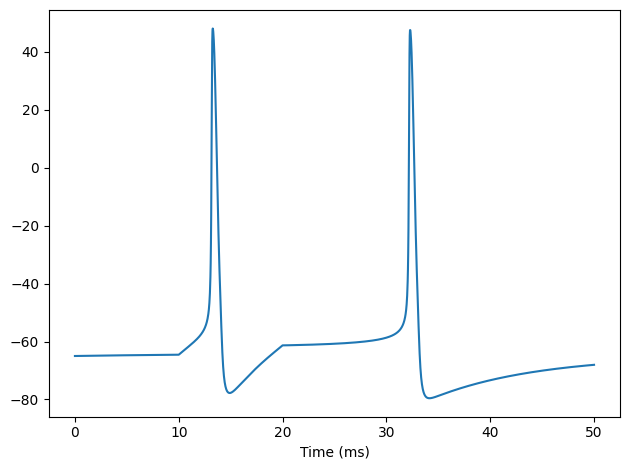

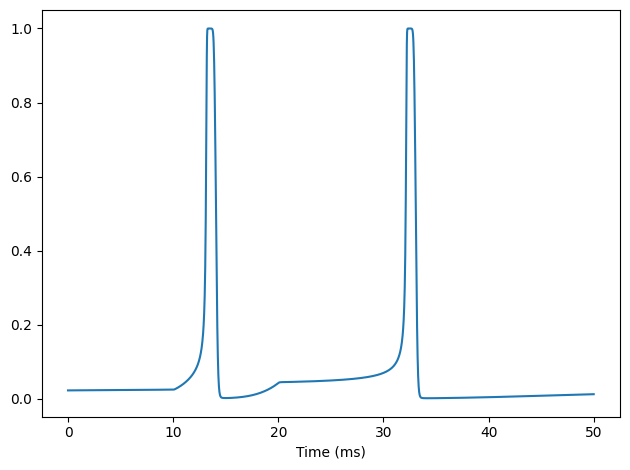

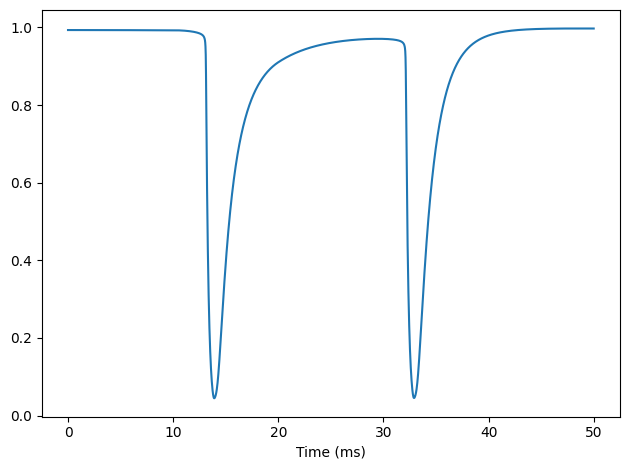

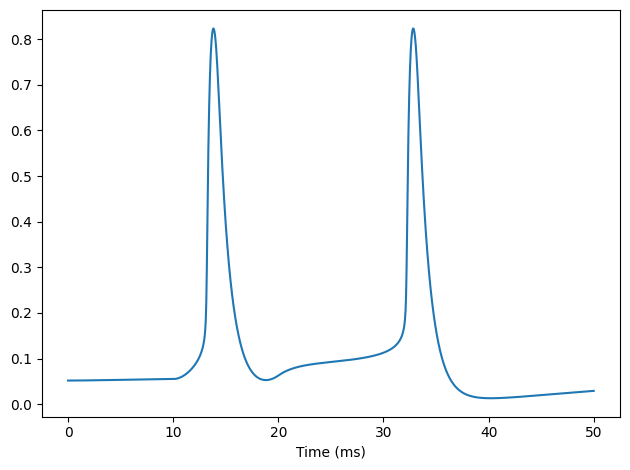

In [8]:
T = 50.0
I_amp = 3.0
I = lambda t: I_amp if 10.0 <= t < 20.0 else 0.0

data = simulate_hh(cfg, I, T)

plot_trajectory(data["t"], data["V"])
plot_trajectory(data["t"], data["m"])
plot_trajectory(data["t"], data["h"])
plot_trajectory(data["t"], data["n"])


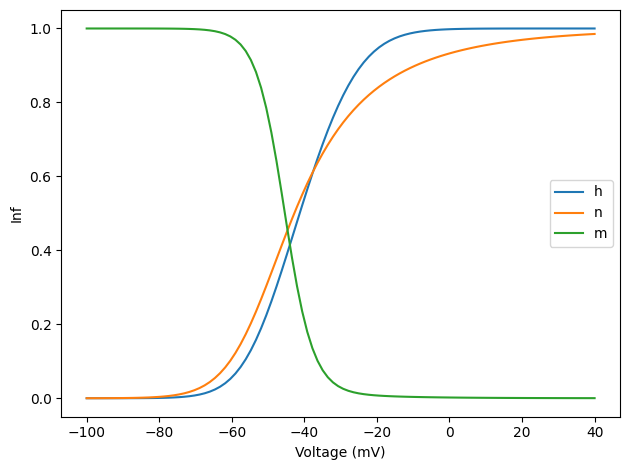

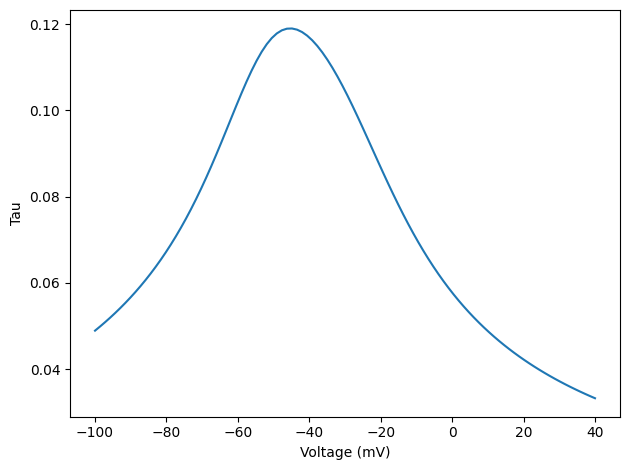

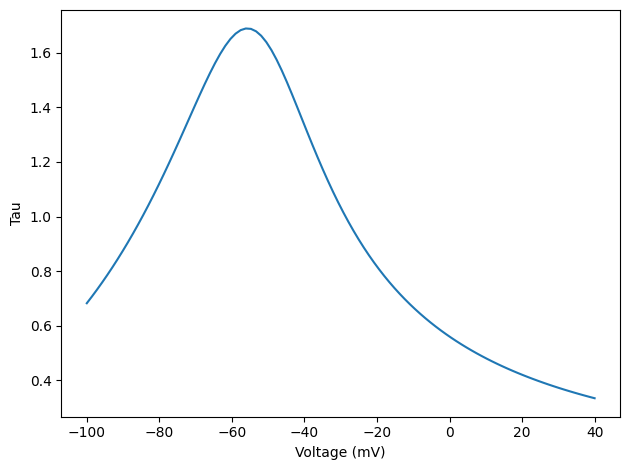

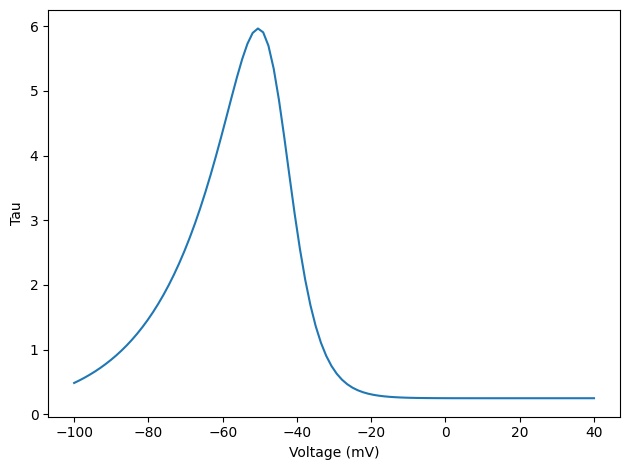

In [9]:
v_array = np.linspace(-100, 40, 100)

tau_m_array = tau_x(v_array, alpha_m, beta_m)
tau_n_array = tau_x(v_array, alpha_n, beta_n)
tau_h_array = tau_x(v_array, alpha_h, beta_h)

x_inf_m_array = x_inf(v_array, alpha_m, beta_m)
x_inf_n_array = x_inf(v_array, alpha_n, beta_n)
x_inf_h_array = x_inf(v_array, alpha_h, beta_h)

plot_trajectory(v_array, tau_m_array, xlab="Voltage (mV)", ylab="Tau")
plot_trajectory(v_array, tau_n_array, xlab="Voltage (mV)", ylab="Tau")
plot_trajectory(v_array, tau_h_array, xlab="Voltage (mV)", ylab="Tau")